In [61]:
import pandas as pd

df = pd.read_csv('with_hours.csv', compression = 'gzip')


First we need to turn the content we scraped from sec filings in the section 'Other events' into lists of tuples containg the one sentence and the index.

In [62]:
from spacy.lang.en import English
from tokenizer import correct_spaces

nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

def split_text(row):
    return_content = []
    doc = nlp(row['clean_content'])
    for s in doc.sents:
        if len(s.text.split()) > 5:
            return_content.append(( correct_spaces(s.text), row['id'], row['category'] ))
    return return_content

df['split_sents'] = df.apply(lambda x: split_text(x), axis=1)
df['split_sent_length'] = df.apply(lambda x: len(x['split_sents']), axis=1)

after processing we want to use https://github.com/UKPLab/sentence-transformers to create bert embeddings for each sentence in our split_sents tuples. Bert embeddings are vector representation of sentences. Interestingly enough cosine distance between the embeddings also indicate semantic similarity. We can use this property to make clusters of sentences with similar meaning without supervision. The embedding process can take a while, I recommend selecting a subset of the dataframe to start on.

In [63]:
# This is optional
df = df[df['industry'] == 'Biotechnology']


In [64]:
from sentence_transformers import SentenceTransformer

full_sentence_vectors = []
for i, row in df.iterrows():
    full_sentence_vectors.extend(row['split_sents'])
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens') # automatically download this model

embedded = model.encode([x[0] for x in full_sentence_vectors])



Now that we have our embeddings we're going to want to reduce the dimensionality with umap learn and cluster with hdbscan, we'll then create a column for each cluster that is a boolean representation of if the filing text contains a sentence belonging to that cluster. These params are the ones that have worked best for me but feel free to try new ones out.

In [88]:
import umap
import hdbscan

umap_model = umap.UMAP(n_neighbors=500,
                    n_components=100,
                    min_dist=0.1,
                    low_memory=True,
                    angular_rp_forest=False,
                    metric='cosine')
umap_model.fit(embedded)

cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                        metric='euclidean',
                        prediction_data=True,
                        cluster_selection_method='eom')
cluster.fit(umap_model.embedding_)

filing_text_ids_cluster_labels_zip = zip([x[1] for x in full_sentence_vectors], cluster.labels_)

before we go further let's take a quick detour and visualize with umap plot, we'll need to reduce our embeddings to 2 dimensions so we can plot it

<AxesSubplot:>

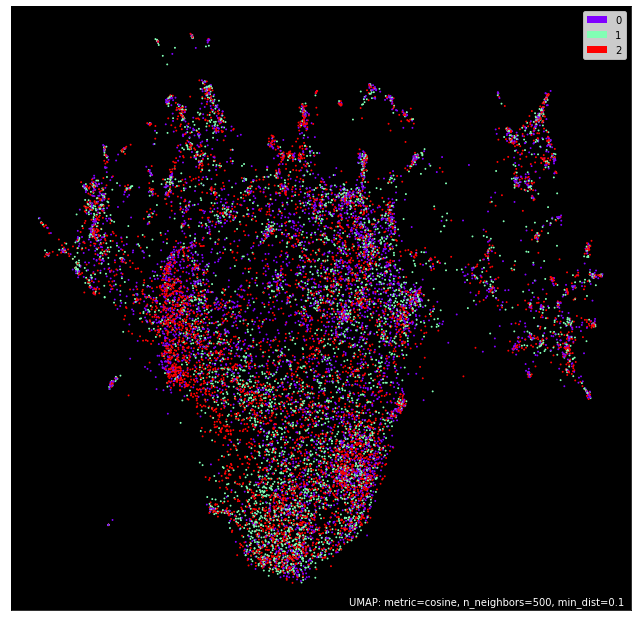

In [87]:
umap_vis = umap.UMAP(n_neighbors=500,
                    n_components=2,
                    min_dist=0.1,
                    low_memory=True,
                    angular_rp_forest=False,
                    metric='cosine')
umap_vis.fit(embedded)
import umap.plot as umap_plot
import numpy as np
umap_plot.points(umap_vis, labels=np.asarray([x[2] for x in full_sentence_vectors]), theme='fire')

The `filing_text_ids_cluster_labels_zip` contains tuples with the values ( dataframe id, cluster id ) for each sentence throughout the filing texts. Now we'll iterate through it and add the cluster columns for our decision tree to make predictions on.

In [89]:

for filing_text_id, cluster_label in filing_text_ids_cluster_labels_zip:
    if f'cluster_id_{cluster_label}' not in df:
        df[f'cluster_id_{cluster_label}'] = 0
    idx = df.index[df['id'] == filing_text_id][0]
    df.loc[idx, f'cluster_id_{cluster_label}'] = 1
    
y = df['category'].values # create our target

x = df.drop(columns=['id', 'pct_change_open', 'clean_content', 'category', 'symbol', 'industry', 'split_sents', 'item_types', 'cluster_id_-1', 'pct_change_close'])



In [90]:
def add_datepart(df, fldname, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
        'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[n] = getattr(fld.dt, n.lower())
    df.drop(columns=[fldname], inplace=True)

add_datepart(x, 'percise_date', time=True)

<ipython-input-90-2f2911e82fb6>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[n] = getattr(fld.dt, n.lower())


Now we're ready to train our decision tree. First we'll split into training and testing

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = RandomForestClassifier(n_estimators=1250,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                max_features= 'auto',
                                max_depth=None,
                                bootstrap=True)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.4